In [1]:
NUMBER_LAYERS = 6
SAVING_PATH = "./saved_weights"
LEARNING_RATE = 0.0005

In [2]:
print("importing packages...")

# original ones from the sparse linear regression example
import numpy as np
import bayesflow as bf
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# additional ones from the SIR tutorial
import datetime
from functools import partial
import pandas as pd
print("successfully imported packages.")

importing packages...


successfully imported packages.


c:\Users\ellio\OneDrive\Desktop\Python\Python_environments\test_env\Lib\site-packages\bayesflow\trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
RNG = np.random.default_rng(2023)

In [4]:
def model_prior():
    """Generates a random draw from the joint prior."""

    lambd = RNG.lognormal(mean=np.log(0.4), sigma=0.5)
    # mu = RNG.lognormal(mean=np.log(1 / 8), sigma=0.2)
    # D = RNG.lognormal(mean=np.log(8), sigma=0.2)
    I0 = RNG.gamma(shape=2, scale=20)
    psi = RNG.exponential(5)
    # return np.array([lambd, mu, D, I0, psi])
    # return np.array([lambd, mu, I0])
    return np.array([lambd, I0, psi])

In [5]:
# prior = bf.simulation.Prior(prior_fun=model_prior, param_names=[r"$\lambda$", r"$\mu$", r"$L$", r"$I_0$", r"$\psi$"])
# prior = bf.simulation.Prior(prior_fun=model_prior, param_names=[r"$\lambda$", r"$\mu$", r"$I_0$"])
prior = bf.simulation.Prior(prior_fun=model_prior, param_names=[r"$\lambda$", r"$I_0$", r"$\psi$"])
prior_means, prior_stds = prior.estimate_means_and_stds()


In [6]:
from scipy.stats import nbinom


def convert_params(mu, phi):
    """Helper function to convert mean/dispersion parameterization of a negative binomial to N and p,
    as expected by numpy's negative_binomial.

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """

    r = phi
    var = mu + 1 / r * mu**2
    p = (var - mu) / var
    return r, 1 - p


def stationary_SIR(params, N, T, eps=1e-5):
    """Performs a forward simulation from the stationary SIR model given a random draw from the prior."""

    # Extract parameters and round I0 and D
    # lambd, mu, D, I0, psi = params
    # lambd, mu, I0 = params
    lambd, I0, psi = params
    D = 0
    mu = .1
    # psi = 1
    I0 = np.ceil(I0)
    D = int(round(D))

    # Initial conditions
    S, I, R = [N - I0], [I0], [0]

    # Reported new cases
    C = [I0]

    # Simulate T-1 timesteps
    for t in range(1, T + D):
        # Calculate new cases
        I_new = lambd * (I[-1] * S[-1] / N)

        # SIR equations
        S_t = S[-1] - I_new
        I_t = np.clip(I[-1] + I_new - mu * I[-1], 0.0, N)
        R_t = np.clip(R[-1] + mu * I[-1], 0.0, N)

        # Track
        S.append(S_t)
        I.append(I_t)
        R.append(R_t)
        C.append(I_new)

    reparam = convert_params(np.clip(np.array(C[D:]), 0, N) + eps, psi)
    C_obs = RNG.negative_binomial(reparam[0], reparam[1])
    return C_obs[:, np.newaxis]


In [7]:
def load_data():
    """Helper function to load cumulative cases and transform them to new cases."""

    confirmed_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    confirmed_cases = pd.read_csv(confirmed_cases_url, sep=",")

    date_data_begin = datetime.date(2020, 3, 1)
    date_data_end = datetime.date(2020, 3, 15)
    format_date = lambda date_py: f"{date_py.month}/{date_py.day}/{str(date_py.year)[2:4]}"
    date_formatted_begin = format_date(date_data_begin)
    date_formatted_end = format_date(date_data_end)

    cases_obs = np.array(
        confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", date_formatted_begin:date_formatted_end]
    )[0]
    new_cases_obs = np.diff(cases_obs)
    return new_cases_obs


In [ ]:
# data used
config = {"T": 14, "N": 83e6, "obs_data": np.array([  33,   38,   74,  138,  239,  156,  107,  237,  157,  271,  802,
        693,  733, 1043], dtype=np.int64)}

In [10]:
simulator = bf.simulation.Simulator(simulator_fun=partial(stationary_SIR, T=config["T"], N=config["N"]))


In [11]:
model = bf.simulation.GenerativeModel(prior, simulator, name="basic_covid_simulator")


INFO:root:Performing 2 pilot runs with the basic_covid_simulator model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 14, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [12]:
summary_net = bf.networks.SequenceNetwork()


In [13]:
inference_net = bf.networks.InvertibleNetwork(num_params=len(prior.param_names), num_coupling_layers=NUMBER_LAYERS)


In [14]:
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net, name="covid_amortizer")


In [15]:
def configure_input(forward_dict):
    """Function to configure the simulated quantities (i.e., simulator outputs)
    into a neural network-friendly (BayesFlow) format.
    """

    # Prepare placeholder dict
    out_dict = {}

    # Convert data to logscale
    logdata = np.log1p(forward_dict["sim_data"]).astype(np.float32)

    # Extract prior draws and z-standardize with previously computed means
    params = forward_dict["prior_draws"].astype(np.float32)
    params = (params - prior_means) / prior_stds

    # Remove a batch if it contains nan, inf or -inf
    idx_keep = np.all(np.isfinite(logdata), axis=(1, 2))
    if not np.all(idx_keep):
        print("Invalid value encountered...removing from batch")

    # Add to keys
    out_dict["summary_conditions"] = logdata[idx_keep]
    out_dict["parameters"] = params[idx_keep]

    return out_dict


In [16]:
trainer = bf.trainers.Trainer(amortizer=amortizer, 
                              generative_model=model, 
                              configurator=configure_input, 
                              checkpoint_path=SAVING_PATH,
                              default_lr=LEARNING_RATE,
                              memory=True)

INFO:root:Initialized empty loss history.
INFO:root:Initialized empty simulation memory.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [17]:
amortizer.summary()

Model: "covid_amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  439404    
 ibleNetwork)                                                    
                                                                 
 sequence_network (Sequence  multiple                  91178     
 Network)                                                        
                                                                 
Total params: 530582 (2.02 MB)
Trainable params: 530546 (2.02 MB)
Non-trainable params: 36 (144.00 Byte)
_________________________________________________________________


In [18]:
offline_data = model(80000) # same number as VaNBayes

In [19]:
%%time
history = trainer.train_offline(offline_data, epochs=20, batch_size=32, validation_sims=20000)

INFO:root:Generated 20000 simulations for validation.
Training epoch 1: 100%|██████████| 2500/2500 [01:04<00:00, 38.94it/s, Epoch: 1, Batch: 2500,Loss: -0.213,W.Decay: 0.159,Avg.Loss: 0.829,Avg.W.Decay: 0.202,LR: 4.97E-04]
INFO:root:Validation, Epoch: 1, Loss: -0.014
Training epoch 2: 100%|██████████| 2500/2500 [00:56<00:00, 44.30it/s, Epoch: 2, Batch: 2500,Loss: 0.050,W.Decay: 0.121,Avg.Loss: 0.089,Avg.W.Decay: 0.138,LR: 4.88E-04] 
INFO:root:Validation, Epoch: 2, Loss: -0.154
Training epoch 3: 100%|██████████| 2500/2500 [00:57<00:00, 43.62it/s, Epoch: 3, Batch: 2500,Loss: 0.246,W.Decay: 0.099,Avg.Loss: -0.051,Avg.W.Decay: 0.109,LR: 4.73E-04] 
INFO:root:Validation, Epoch: 3, Loss: 0.280
Training epoch 4: 100%|██████████| 2500/2500 [01:00<00:00, 41.49it/s, Epoch: 4, Batch: 2500,Loss: -0.529,W.Decay: 0.084,Avg.Loss: -0.122,Avg.W.Decay: 0.091,LR: 4.52E-04]
INFO:root:Validation, Epoch: 4, Loss: -0.282
Training epoch 5: 100%|██████████| 2500/2500 [01:04<00:00, 38.57it/s, Epoch: 5, Batch: 25

CPU times: total: 5min 26s
Wall time: 20min 23s


## Validation

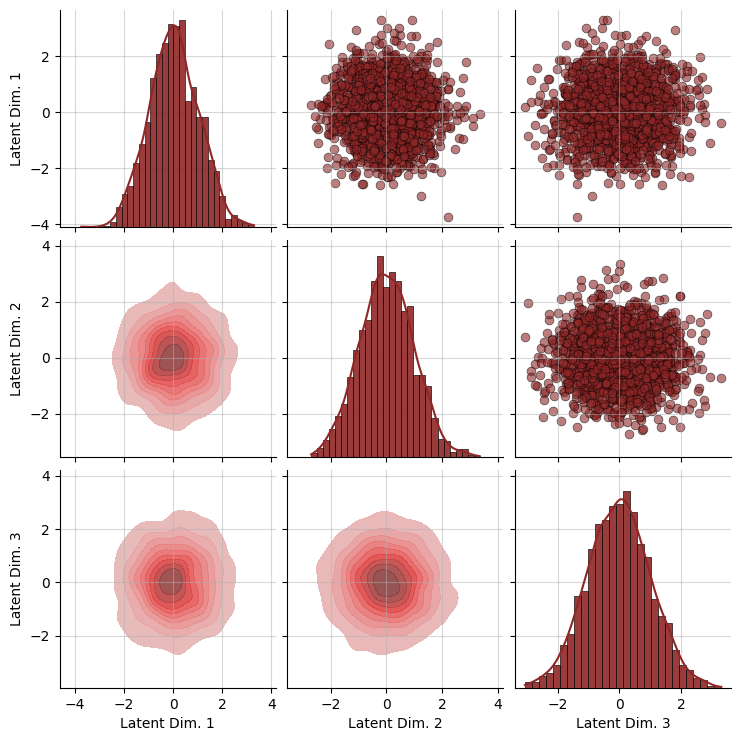

In [ ]:
f = trainer.diagnose_latent2d()


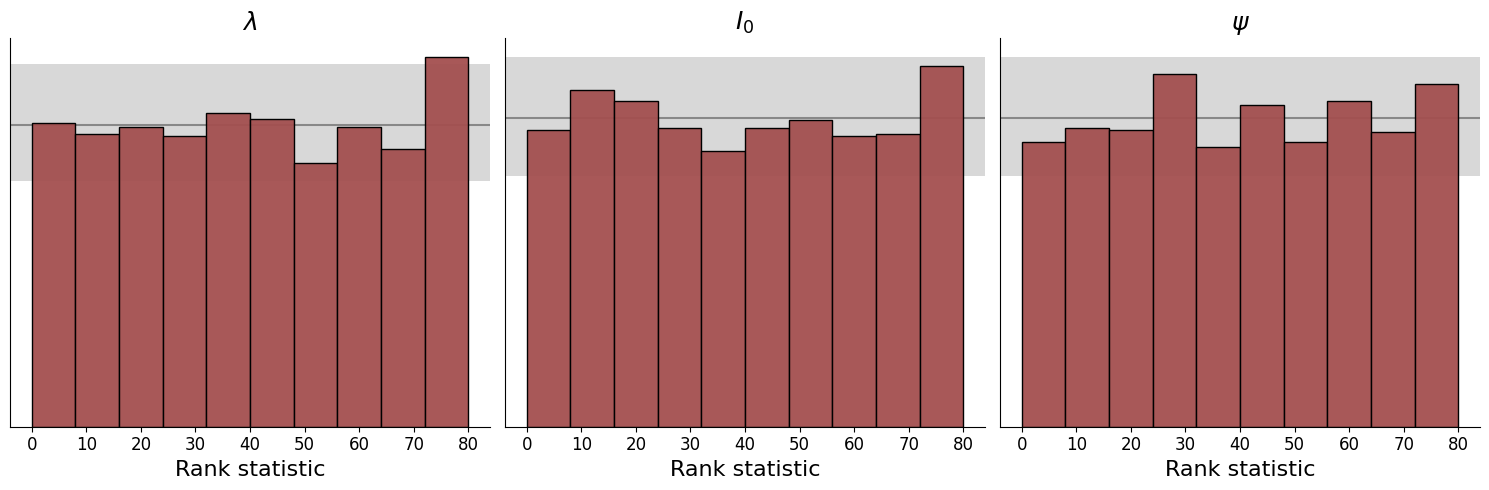

In [ ]:
f = trainer.diagnose_sbc_histograms()


In [ ]:
# Generate some validation data
validation_sims = trainer.configurator(model(batch_size=300))

# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=100)


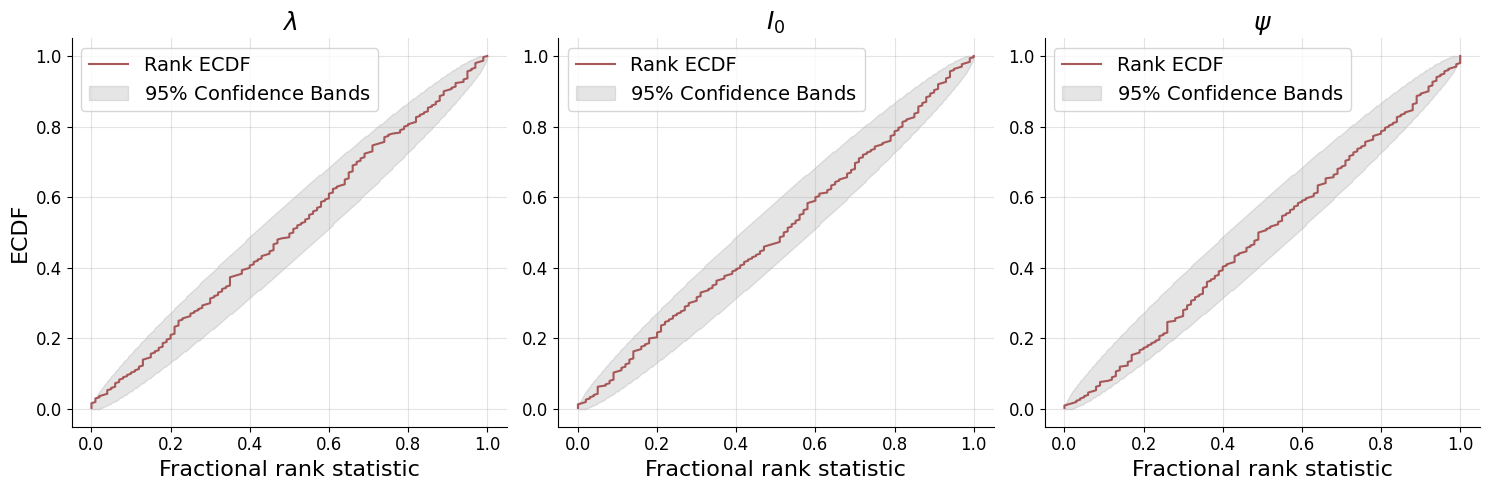

In [ ]:
# Create ECDF plot
f = bf.diagnostics.plot_sbc_ecdf(post_samples, validation_sims["parameters"], param_names=prior.param_names)


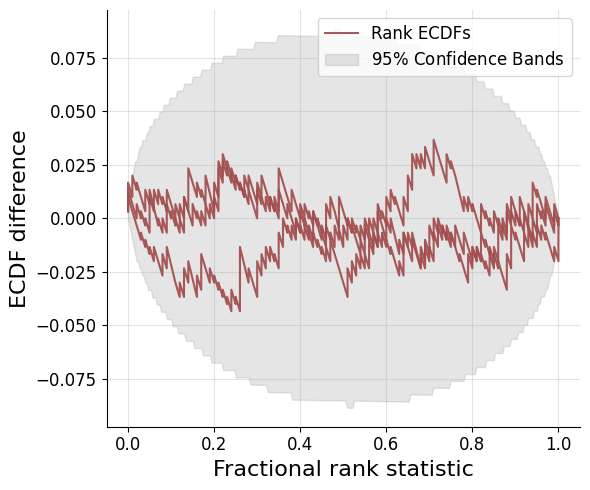

In [ ]:
f = bf.diagnostics.plot_sbc_ecdf(
    post_samples, validation_sims["parameters"], stacked=True, difference=True, legend_fontsize=12, fig_size=(6, 5)
)


INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 3.                    Confidence intervals might be unreliable!


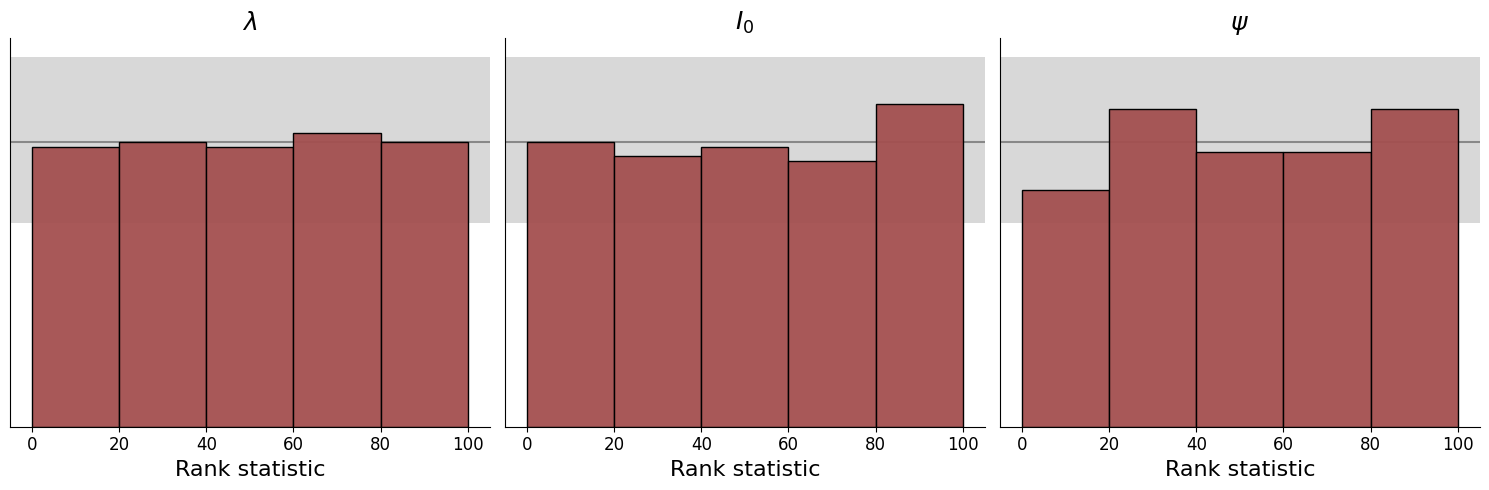

In [ ]:
f = bf.diagnostics.plot_sbc_histograms(post_samples, validation_sims["parameters"], param_names=prior.param_names)


In [ ]:
post_samples = amortizer.sample(validation_sims, n_samples=1000)


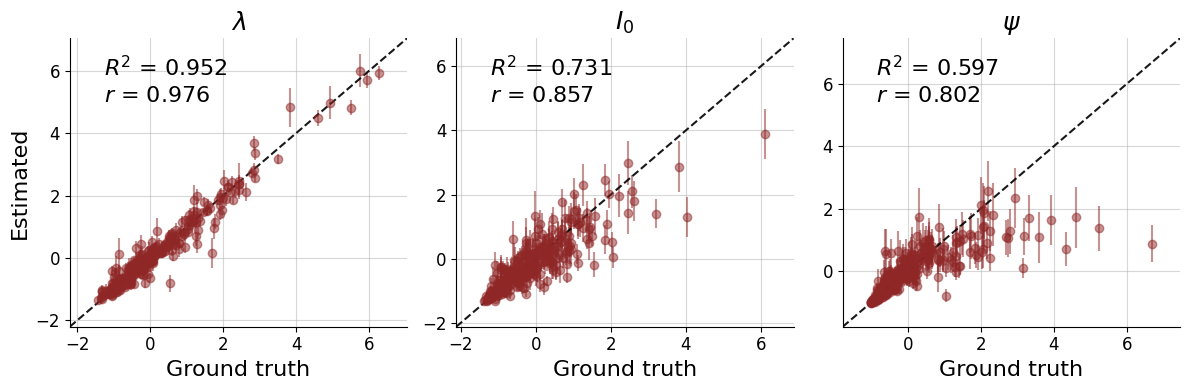

In [ ]:
f = bf.diagnostics.plot_recovery(post_samples, validation_sims["parameters"], param_names=prior.param_names)


# Diagnostics with the observed Data

In [ ]:
# Format data into a 3D array of shape (1, n_time_steps, 1) and perform log transform
obs_data = np.log1p(config["obs_data"])[np.newaxis, :, np.newaxis].astype(np.float32)


In [ ]:
obs_data.shape

(1, 14, 1)

In [ ]:
# Obtain 500 posterior draws given real data
post_samples = amortizer.sample({"summary_conditions": obs_data}, 500)

# Undo standardization to get parameters on their original (unstandardized) scales
post_samples = prior_means + post_samples * prior_stds


In [ ]:
post_samples.shape

(500, 3)

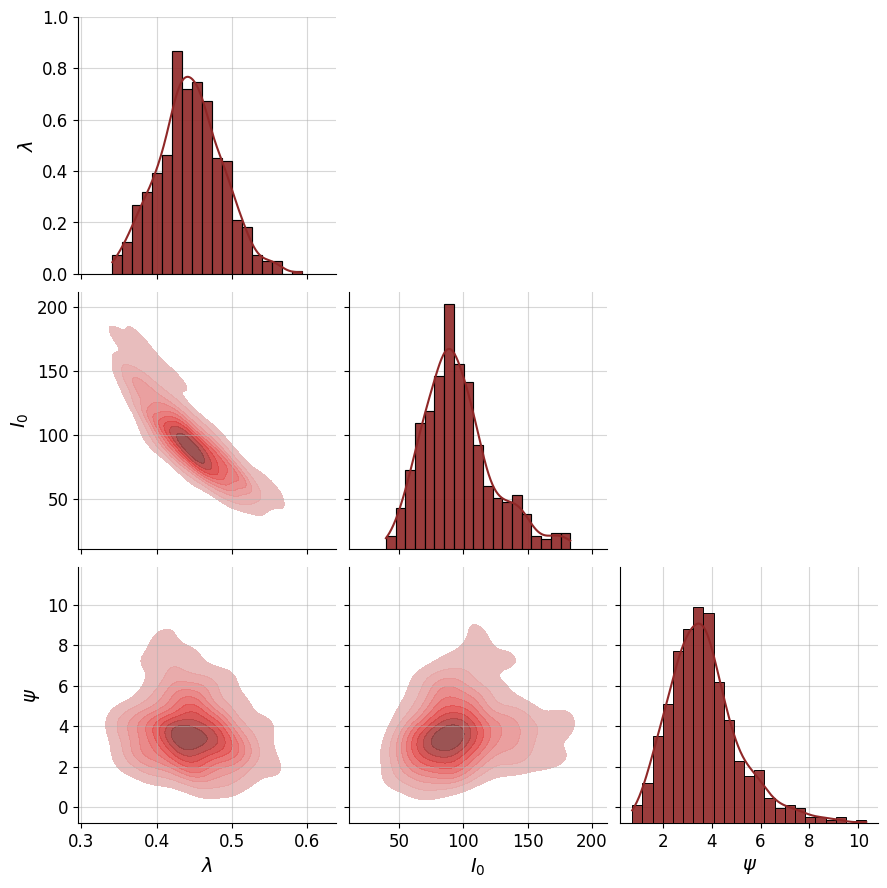

In [ ]:
f = bf.diagnostics.plot_posterior_2d(post_samples, param_names=prior.param_names)


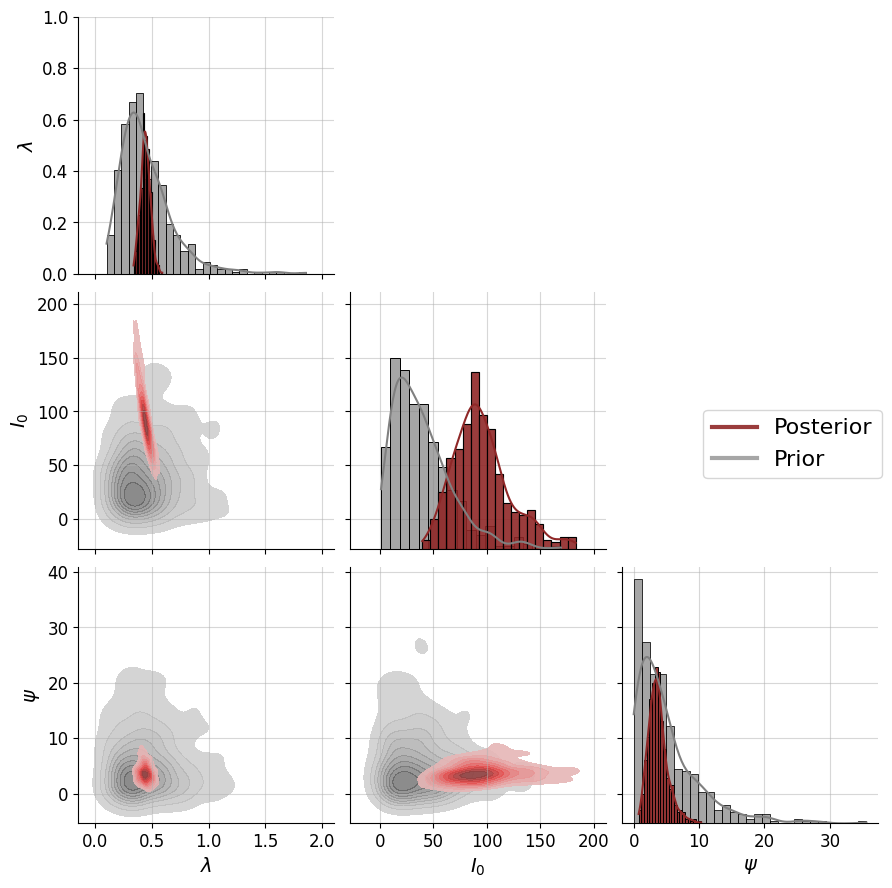

In [ ]:
f = bf.diagnostics.plot_posterior_2d(post_samples, prior=prior)


In [ ]:
import matplotlib.pyplot as plt


def plot_ppc(config, post_samples, logscale=True, color="#8f2727", dummy=True, figsize=(12, 6), font_size=18):
    """
    Helper function to perform some plotting of the posterior predictive.
    """
    # Plot settings
    plt.rcParams["font.size"] = font_size

    # Remove parameters < 0
    samples = post_samples[np.sum(post_samples < 0, axis=1) == 0]

    f, ax = plt.subplots(1, 1, figsize=figsize)

    # Re-simulations
    sims = []
    for i in range(samples.shape[0]):
        # Note - simulator returns 2D arrays of shape (T, 1), so we remove trailing dim
        sim_cases = stationary_SIR(samples[i], config["N"], config["T"])[:, 0]
        sims.append(sim_cases)
    sims = np.array(sims)

    # Compute quantiles for each t = 1,...,T
    qs_50 = np.quantile(sims, q=[0.25, 0.75], axis=0)
    qs_90 = np.quantile(sims, q=[0.05, 0.95], axis=0)
    qs_95 = np.quantile(sims, q=[0.025, 0.975], axis=0)

    # Plot median predictions and observed data
    ax.plot(np.median(sims, axis=0), label="Median predicted cases", color=color)
    ax.plot(config["obs_data"], marker="o", label="Reported cases", color="black", linestyle="dashed", alpha=0.8)

    # Add compatibility intervals (also called credible intervals)
    ax.fill_between(range(config["T"]), qs_50[0], qs_50[1], color=color, alpha=0.5, label="50% CI")
    ax.fill_between(range(config["T"]), qs_90[0], qs_90[1], color=color, alpha=0.3, label="90% CI")
    ax.fill_between(range(config["T"]), qs_95[0], qs_95[1], color=color, alpha=0.1, label="95% CI")

    # Grid and schmuck
    ax.grid(color="grey", linestyle="-", linewidth=0.25, alpha=0.5)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("Days since pandemic onset")
    ax.set_ylabel("Number of cases")
    ax.minorticks_off()
    if logscale:
        ax.set_yscale("log")
    ax.legend(fontsize=font_size)
    return f


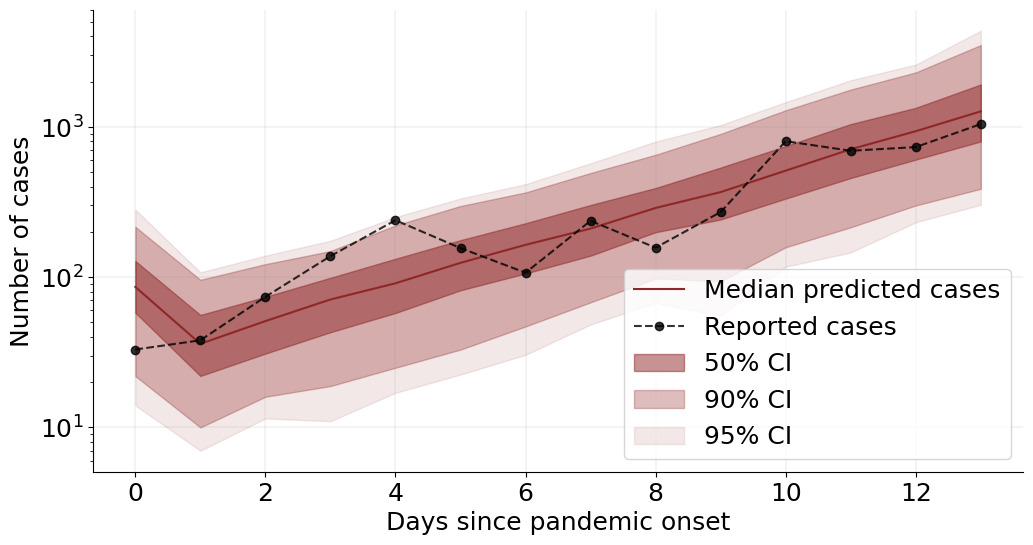

In [ ]:
f = plot_ppc(config, post_samples)


# Simulation Study

In [ ]:
# importing the simulation study datasets
arr = np.loadtxt("sim_study_datasets.csv", delimiter=",", dtype=str)
trimmed_arr = arr[1:,1:]
int_trimmed_arr = np.array(trimmed_arr, dtype = np.int64)
int_trimmed_arr.shape

(100, 14)

In [ ]:
# the simulation study settings
posterior_resolution = 10000
nsims = int_trimmed_arr.shape[0]
nparams = 3

# true values
true_lambda = .4
true_I0 = 20
true_psi = 5
true_parameters = [true_lambda, true_I0, true_psi]

# helper functions
def get_quantiles(x):
    return(np.array([np.quantile(x, .05), np.quantile(x, .50), np.quantile(x, .95)]))

In [ ]:
parameters_captured = np.array([0,0,0], np.uint8)
parameter_ADs = np.zeros((nsims, nparams))
posterior_medians = np.zeros((nsims, nparams))
for i in range(nsims): # for each of the 100 datasets...
    # print(i)
    # format the simulation study dataset
    obs_data = np.log1p(int_trimmed_arr[i,:])[np.newaxis, :, np.newaxis].astype(np.float32)
    # Obtain posterior draws
    post_samples = amortizer.sample({"summary_conditions": obs_data}, posterior_resolution)
    # Undo standardization to get parameters on their original (unstandardized) scales
    post_samples = prior_means + post_samples * prior_stds

    # get the posterior quantiles
    median_and_90credible_interval = np.apply_along_axis(get_quantiles, 0, post_samples)

    for j in range(nparams):

        # coverage capturing
        if (median_and_90credible_interval[0,j] < true_parameters[j])&(true_parameters[j] < median_and_90credible_interval[2,j]):
            parameters_captured[j] = parameters_captured[j] + 1

        # absolute deviation
        parameter_ADs[i,j] = np.abs(median_and_90credible_interval[1,j] - true_parameters[j])

        # save the medians to send to R
        posterior_medians[i,j] = median_and_90credible_interval[1,j]

# final averaging calculations:
parameter_coverage = parameters_captured/nsims
parameter_MAD = np.apply_along_axis(np.mean, 0, parameter_ADs)
print("parameter_coverage")
print(parameter_coverage)
print("parameter_MAD")
print(parameter_MAD)

parameter_coverage
[0.93 0.94 0.94]
parameter_MAD
[0.02765741 4.72405207 1.74360967]


In [ ]:
np.savetxt("bayesflow_posterior_medians.csv", posterior_medians, delimiter=",")